# Dataset Preparation

In [4]:
from glob import glob

image_files = glob("data/social-posts/*.jpg")

text_files = glob("data/social-posts/*.txt")

print(len(image_files), len(text_files))

40 40


In [5]:
print(image_files[1], text_files[1])

data/social-posts\10.jpg data/social-posts\10.txt


In [7]:
documents = []

for i in range(1, len(image_files)+1):
    text_file  = f'data/social-posts/{i}.txt'
    image_file = f'data/social-posts/{i}.jpg'
    
    text = open(text_file, encoding="utf-8", errors="ignore").read()
    doc = {"text": text, "image":image_file}
    documents.append(doc)

11 Types of Variables in a Dataset!

Beyond features and targets, datasets include various variable types essential for analysis.

1-2) Independent and Dependent Variables

Independent Variables: Inputs used to predict outcomes.
Dependent Variable: The outcome being predicted.

3) Interaction Variables

Capture combined effects of two or more variables, often in regression analysis.

4) Latent Variables

Not directly observed but inferred from other variables.
Example: In clustering, true labels are latent variables inferred from data.

5-7) Confounding, Correlated, and Control Variables

Confounding Variables: Affect both independent and dependent variables, potentially biasing results.
Example: Temperature influences both ice cream and air conditioner sales.
Control Variables: Accounted for to eliminate bias from confounders.

8) Leaky Variables

Unintentionally reveal information about the target not available at prediction time.

9-10) Stationary and Non-Stationary Variables

Stati

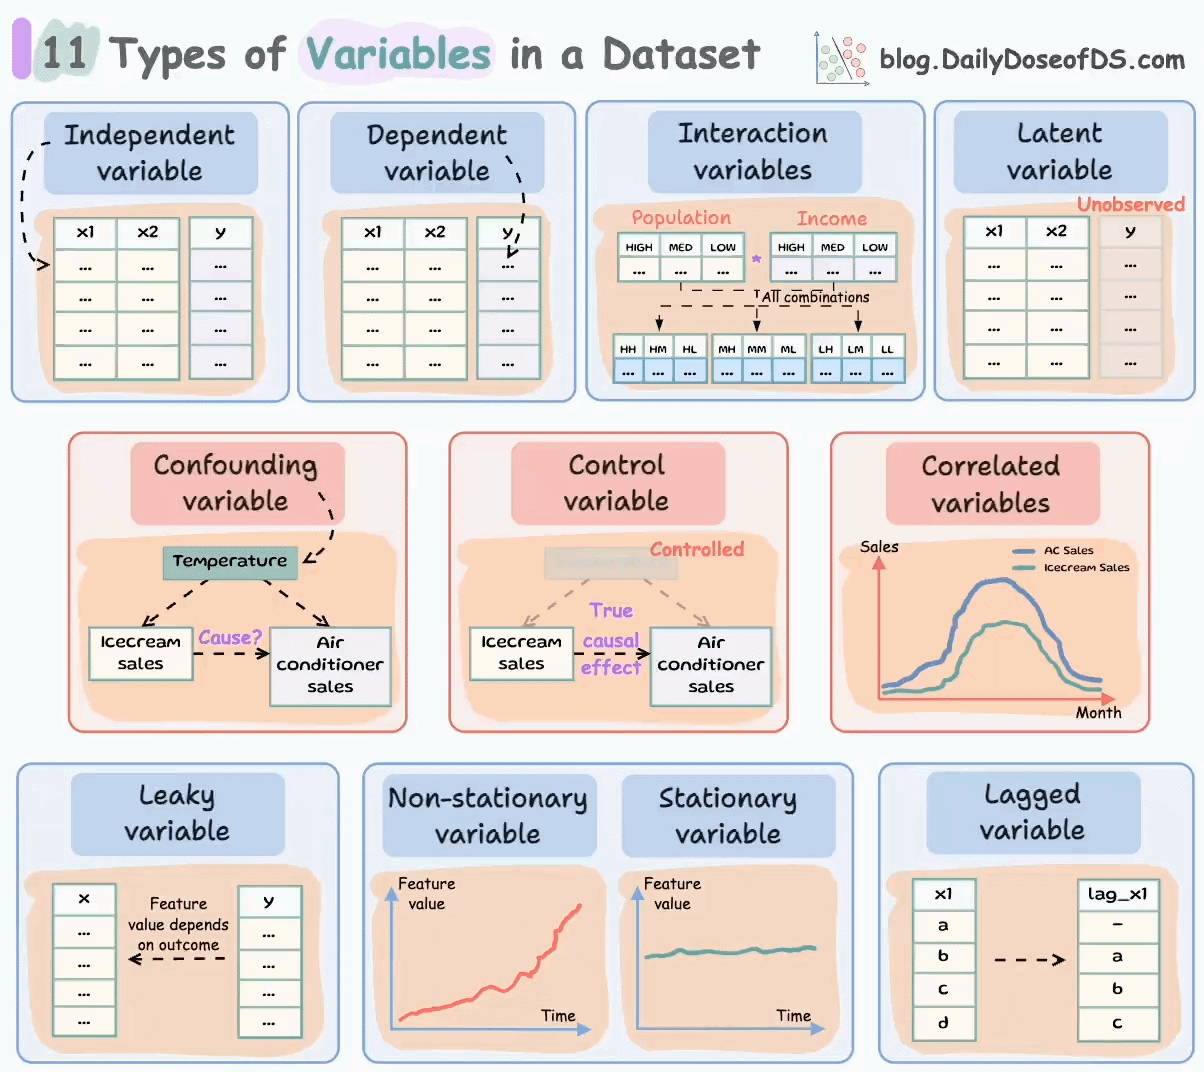

In [8]:
import random
from PIL import Image

num = random.randint(0, len(documents)-1)

# print text
print(documents[num]["text"])

# display image
display(Image.open(documents[num]["image"]))

# Embed Dataset

In [9]:
# !pip install fastembed

from fastembed import TextEmbedding, ImageEmbedding

class EmbedData:
    def __init__(self,
                 documents,
                 text_model_name="Qdrant/clip-ViT-B-32-text",
                 image_model_name="Qdrant/clip-ViT-B-32-vision"):

        # Initialize text embedding model
        self.documents = documents
        self.text_model = TextEmbedding(model_name=text_model_name)
        self.text_embed_dim = self.text_model._get_model_description(text_model_name)["dim"]
        
        # Initialize image embedding model
        self.image_model = ImageEmbedding(model_name=image_model_name)
        self.image_embed_dim = self.image_model._get_model_description(image_model_name)["dim"]
    
    def embed_texts(self, texts):
        text_embeddings = list(self.text_model.embed(texts))
        return text_embeddings
    
    def embed_images(self, images):
        image_embeddings = list(self.image_model.embed(images))
        return image_embeddings

c:\Users\manideep\Documents\Learnings\RAGs_deepdive\ragEnv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
embeddata = EmbedData(documents)

embeddata.text_embeds  = embeddata.embed_texts([doc["text"] for doc in documents])

embeddata.image_embeds = embeddata.embed_images([doc["image"] for doc in documents])

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]c:\Users\manideep\Documents\Learnings\RAGs_deepdive\ragEnv\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\manideep\AppData\Local\Temp\fastembed_cache\models--Qdrant--clip-ViT-B-32-text. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Fetching 3 fil

In [11]:
import numpy as np

print(np.array(embeddata.text_embeds))

[[-0.00478196  0.02521464 -0.0595684  ... -0.08059194 -0.02418593
   0.01228002]
 [ 0.02167795 -0.01376178  0.01594471 ... -0.03696359 -0.04793457
  -0.00111403]
 [-0.00744008  0.01540474  0.01275509 ... -0.07251235 -0.03039219
   0.04412259]
 ...
 [-0.01061978 -0.01621294 -0.00216255 ... -0.09081446 -0.0033549
  -0.00257717]
 [ 0.01164328  0.0552448  -0.0567756  ... -0.01943809 -0.02235425
   0.04530266]
 [ 0.02053607  0.03772461 -0.08860212 ... -0.0741692  -0.01034645
   0.04060551]]


# Define vector store

In [12]:
from qdrant_client import QdrantClient, models

class QdrantVDB:
    def __init__(self,
                 collection_name,
                 image_dim,
                 text_dim,
                 url="http://localhost:6333"):

        self.image_dim = image_dim
        self.text_dim = text_dim
        self.collection_name = collection_name
        self.client = QdrantClient(url=url, prefer_grpc=True)
    

    def create_collection(self):

        if not self.client.collection_exists(self.collection_name):
        
            print(f"Creating collection '{self.collection_name}'...")
        
            self.client.create_collection(
                collection_name=self.collection_name,
                
                vectors_config={
                    "image": models.VectorParams(size=self.image_dim,
                                                 distance=models.Distance.COSINE),
                    "text": models.VectorParams(size=self.text_dim,
                                                distance=models.Distance.COSINE),
                }
            )
        
            print(f"Collection '{self.collection_name}' created successfully.")
        
        else:
            print(f"Collection '{self.collection_name}' already exists.")
        
    def upload_embeddings(self, embeddata):

        print(f"Uploading points to collection '{self.collection_name}'...")
        
        points = []
        
        for idx, doc in enumerate(embeddata.documents):
            point = models.PointStruct(id=idx,  # Unique ID for each point
                                       vector={
                                           "text": embeddata.text_embeds[idx], 
                                           "image": embeddata.image_embeds[idx]
                                           },
                                       payload=doc  # Original image and its caption
                                       )
        
            points.append(point)

        self.client.upload_points(collection_name=self.collection_name, points=points)
        
        print(f"Uploaded {len(points)} points to collection '{self.collection_name}'.")

In [13]:
vector_db = QdrantVDB("linkedin-posts",
                      embeddata.image_embed_dim,
                      embeddata.text_embed_dim)

vector_db.create_collection()

vector_db.upload_embeddings(embeddata)

Creating collection 'linkedin-posts'...
Collection 'linkedin-posts' created successfully.
Uploading points to collection 'linkedin-posts'...
Uploaded 40 points to collection 'linkedin-posts'.


# Define Retriever class

In [14]:
class Retriever:

    def __init__(self, vector_db, embeddata):
        
        self.vector_db = vector_db
        self.embeddata = embeddata

    def search(self, query, limit=3):
        query_embedding = list(self.embeddata.embed_texts(query))[0]

        result = self.vector_db.client.search(
                collection_name=self.vector_db.collection_name,
                query_vector=("image", query_embedding),
                with_payload=["image", "text"], 
                limit=limit
            )

        return result

A single frame summary of 6 types of clustering algorithms.

Centroid-based is the most common class of clustering. Yet, there's a whole world of algorithms beyond that, which we all should be aware of.

- Centroid-based: Cluster data points based on proximity to centroids.

- Connectivity-based: Cluster points based on proximity between clusters.

- Density-based: Cluster points based on their density. It is more robust to clusters with varying densities and shapes than centroid-based clustering.

- Graph-based: Cluster points based on graph distance.

- Distribution-based: Cluster points based on their likelihood of belonging to the same distribution.

- Compression-based: Transform data to a lower dimensional space and then perform clustering



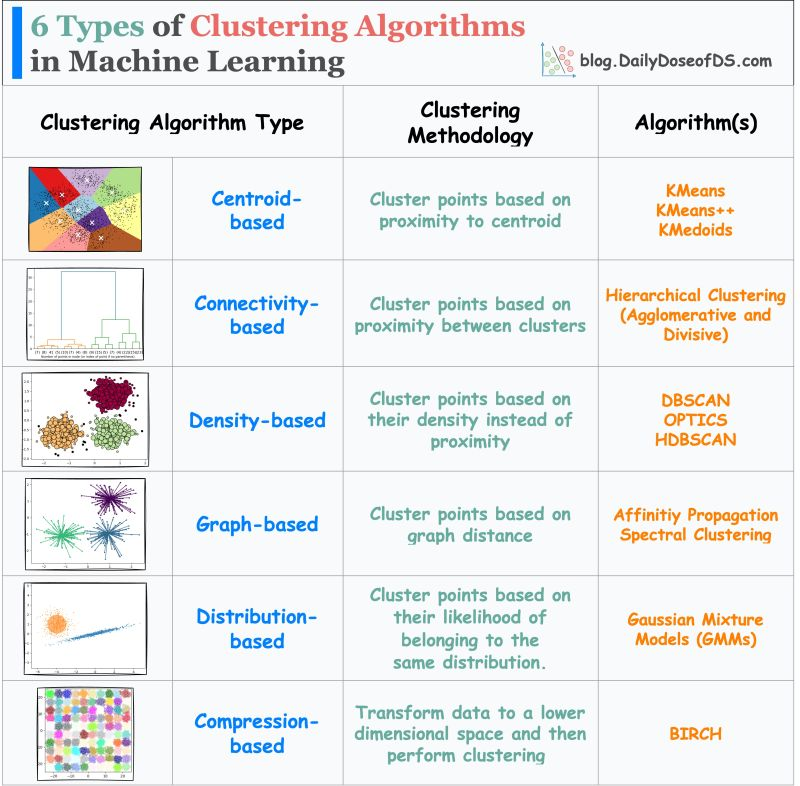

In [15]:
query = "What are some examples of Graph-based clustering algorithms?"

result = Retriever(vector_db, embeddata).search(query, limit=1)

for i in result:
    print(i.payload["text"])
    display(Image.open(i.payload["image"]))

# RAG Class

In [21]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("image-text-to-text", model="meta-llama/Llama-3.2-11B-Vision")

c:\Users\manideep\Documents\Learnings\RAGs_deepdive\ragEnv\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\manideep\.cache\huggingface\hub\models--meta-llama--Llama-3.2-11B-Vision. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


KeyboardInterrupt: 

In [27]:
class RAG:
    def __init__(self,
                 retriever,
                 model_name="meta-llama/Llama-3.2-11B-Vision"):  # Changed to use HF model
        
        self.retriever = retriever
        # Initialize HF model and processor
        self.processor = AutoProcessor.from_pretrained(model_name)
        self.model = AutoModelForVisionQuestionAnswering.from_pretrained(model_name)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(self.device)
        self.qa_prompt_tmpl_str = """Context information is below.
                                     ---------------------
                                     {context}
                                     ---------------------

                                     Some images may also be available to you
                                     for answering the question better. You have
                                     to undersatnd those images thoroughly and 
                                     extra all relevant information that might 
                                     help you answer the query better.

                                     ---------------------
                                     
                                     Given the context information above I want you
                                     to think step by step to answer the query in a
                                     crisp manner, incase case you don't know the
                                     answer say 'I don't know!'
                                     
                                     ---------------------
                                     
                                     Query: {query}
                                     
                                     ---------------------
                                     Answer: """
    
    def generate_context(self, query):
    
        result = self.retriever.search(query)
        context = [dict(data) for data in result]
        combined_prompt = []

        for entry in context:
            context = entry["payload"]["text"]

            combined_prompt.append(context)

        return "\n\n---\n\n".join(combined_prompt), result
    
    def query(self, query):
        context, result = self.generate_context(query=query)
        prompt = self.qa_prompt_tmpl_str.format(context=context,
                                                query=query)
        
        # Load and process image
        image = Image.open(result[0].payload['image'])

                # Prepare inputs for the model
        inputs = self.processor(images=image, text=prompt, return_tensors="pt")
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # Generate response
        with torch.no_grad():
            outputs = self.model.generate(**inputs, max_length=100)
        
        # Decode response
        response = self.processor.batch_decode(outputs, skip_special_tokens=True)[0]
    
        return response

# Using RAG

In [24]:
retriever = Retriever(vector_db, embeddata)

rag = RAG(retriever)

In [ ]:
query = """What are some examples of
           Graph-based clustering algorithms?"""

response = rag.query(query)

In [ ]:
query = """Are there any ways to
           speed up native Python code?"""

response = rag.query(query)

In [ ]:
query = """What is the mathematics behind the
           kernel trick? Show me a step-by-step
           explanation with the polynomial
           kernel and two 2D vectors."""

response = rag.query(query)